# Music Recommender System Final Project

Contributer names: \
\
Mac Beggs \
Arman Keshavarz \
Sammy Suliman

In [1]:
!pip install requests
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## BACKGROUND

For streaming companies, having a recommendation system can help them provide a better experience for a customer by making personalized recommendation.

In this project, we leverage streaming data from the music streaming platform last.fm to build a recommendation system that can provide recommendations using user history and/or information such as age, country, gender, etc.

The dataset we are using comes from here: https://github.com/nachiketmparanjape/Music-Recommender-last.fm
All credit goes to the original creator.

In [382]:
rec_data = pd.read_csv('merged-subset.csv', encoding='cp1252')

In [383]:
rec_data.shape

(10000, 9)

In [384]:
rec_data.head()

,Unnamed: 0,userId,artistId,artist,plays,gender,age,country,signupDate
0,249130,03b9c645bc4f578ea1dcb6a975e7ea71fab79da2,a16371b9-7d36-497a-a9d4-42b0a0440c5e,slowdive,108,m,28.0,Germany,"Sep 16, 2006"
1,16103327,ee48ac7de691d31176a2843d0f2f8f49cab78e6d,5a24bc1a-c093-4a82-84ed-8d7f2da0570d,skinny puppy,407,m,NaN,Canada,"Dec 14, 2006"
2,12079167,b2e3d27a00fc3035edb439b14e6d30bcb6dddf69,68f1175b-592b-4f28-ab1c-85c7a438c636,turbonegro,91,m,29.0,United Kingdom,"Sep 23, 2005"
3,12210583,b4d4909255dc5bb404ff64866cac60164b465e9a,cfd3727e-7162-4e6a-a3f7-a59343ee6b8d,honey is cool,50,NaN,NaN,Denmark,"Dec 22, 2008"
4,7937614,758de8850b5a07875da1e23296e4021574be8596,3bb24e11-821a-4e4e-bd89-e0a2452474cf,useless id,108,m,25.0,Serbia,"Mar 15, 2009"


# DATA ANALYSIS

In [385]:
print('Min. number of plays: ', rec_data['plays'].min())
print('Max. number of plays: ', rec_data['plays'].max())
avg_plays = rec_data['plays'].mean()
print('Avg. number of plays: ', avg_plays)

Min. number of plays:  1
Max. number of plays:  12558
Avg. number of plays:  220.7543


In [386]:
from datetime import datetime

# Parse the date string into a datetime object
rec_data['signupDate'] = rec_data['signupDate'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

# Convert the datetime object to the desired output format "YYYYMMDD"
rec_data['signupDate'] = rec_data['signupDate'].apply(lambda x: x.strftime('%Y%m%d'))
rec_data['signupDate'] = rec_data['signupDate'].apply(int)

print(rec_data['signupDate'].head())  # Output: 20000101

0    20060916
1    20061214
2    20050923
3    20081222
4    20090315
Name: signupDate, dtype: int64


All users signed up for the last.fm service between 2002 and 2009. Let's look individually at the first and last users to signup.

In [387]:
print('First signup date', datetime.strptime(str(rec_data['signupDate'].min()), '%Y%m%d'))
print('Last signup date', datetime.strptime(str(rec_data['signupDate'].max()), '%Y%m%d'))
last_date = rec_data['signupDate'].max()

First signup date 2002-10-29 00:00:00
Last signup date 2009-11-02 00:00:00


In [388]:
rec_data[rec_data['signupDate']==20021029]

,Unnamed: 0,userId,artistId,artist,plays,gender,age,country,signupDate
8608,7217376,6ac689cf16990d84aa24d750847605ae775e6189,ff95eb47-41c4-4f7f-a104-cdc30f02e872,brian eno,237,m,43.0,Sweden,20021029


In [389]:
rec_data[rec_data['signupDate']==20091102]

,Unnamed: 0,userId,artistId,artist,plays,gender,age,country,signupDate
3161,866863,0cdeb54f11ee4346a47c33220668e6762e494ec8,6648391e-7890-4f6c-b939-976f215195d3,unkle,142,m,20.0,France,20091102


Our recommender system will be built off of number of plays since we have no ratings in our dataset. What is the average number of plays?

In [390]:
rec_data['plays'].mean()

220.7543

Most users are only in the dataset one time (i.e, they only listened to a single artist). This may pose challenges later on.

In [391]:
rec_data['userId'].value_counts()

userId
ee93d79f9b97cc03067dd3f4d90f6137cb301229    3
7de1e03e8a9b649bcf42ecde96ab301346601c53    3
32ff4f218c44472229c5d16de21a35e294fd5d10    2
a0549f97f461dc75b195aaa8324c05f0fa766851    2
45d0687e694fcef22de4660ef6e51e950cfb34b5    2
                                           ..
6371191a295fb7babeb98d813159bf2f4fb89c93    1
0b4c3386859abb3db2ca5f3c246156081baa6638    1
210c99699f2db1dfceb200e687c82da357e477a5    1
a2d2881ad3df0a75f450276c6b3287c04cfb0b39    1
57719e71d1265ba42aeca1e3bec5324f3d9a3714    1
Name: count, Length: 9871, dtype: int64

In [392]:
rec_data_sorted = rec_data.sort_values('plays', ascending=False).head(100)

It appears there is one large outlier, a user who listened to almost double the music as the next highest listener.

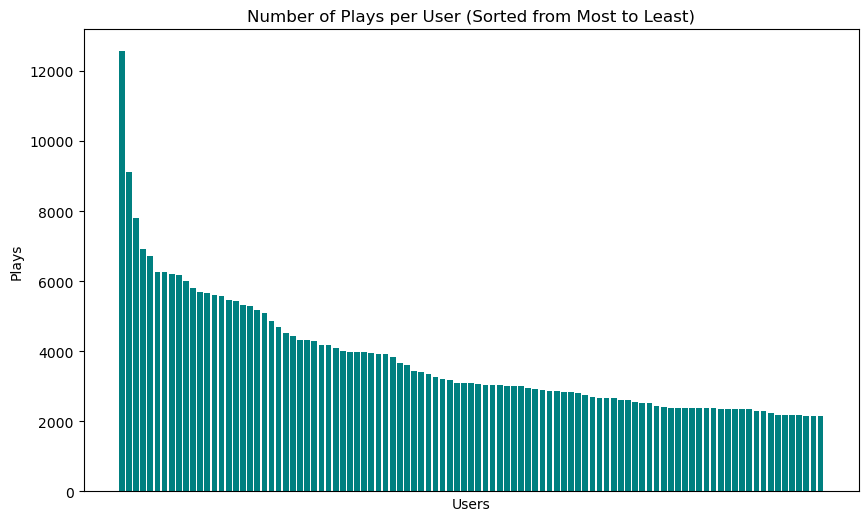

In [393]:
plt.figure(figsize=(10,6))
plt.bar(rec_data_sorted['userId'], rec_data_sorted['plays'], color='teal')
plt.xlabel('Users')
plt.ylabel('Plays')
plt.title('Number of Plays per User (Sorted from Most to Least)')
plt.xticks([])
plt.show()

We want to do our investigations without this outlier potentially altering the results.

In [394]:
rec_data_copy = rec_data[rec_data['plays'] != rec_data['plays'].max()]

In [395]:
rec_data_copy.shape

(9999, 9)

In [396]:
rec_data.shape

(10000, 9)

In [397]:
rec_data['plays'].max()

12558

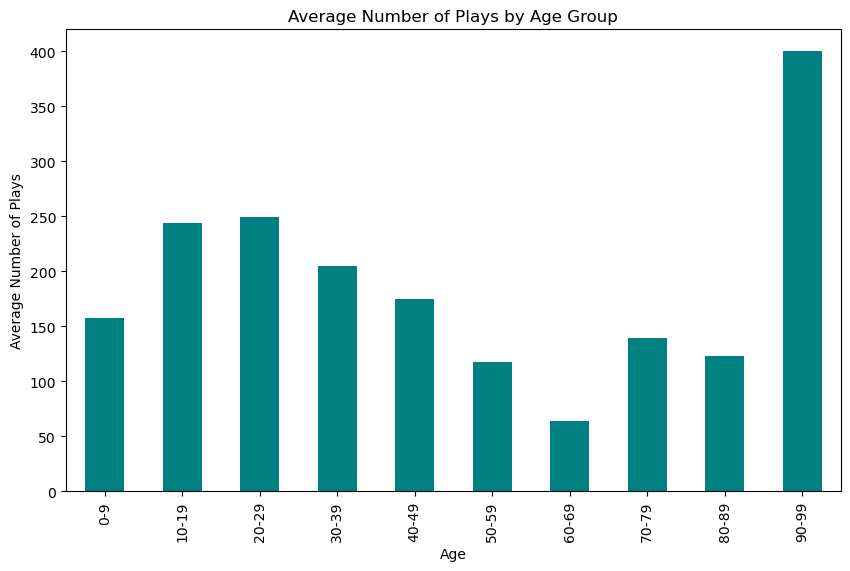

In [398]:
rec_data['age_group'] = pd.cut(rec_data['age'], bins=range(0, 101, 10), right=False, labels=[f"{i}-{i+9}" for i in range(0, 100, 10)])

# Grouping by age group and calculating the average number of plays
age_group_bucket = rec_data.groupby('age_group')['plays'].mean()


# Plotting the data
plt.figure(figsize=(10,6))
age_group_bucket.plot(kind='bar', color='teal')
plt.xlabel('Age')
plt.ylabel('Average Number of Plays')
plt.title('Average Number of Plays by Age Group')
plt.show()

In [399]:
rec_data['age_group'].value_counts()

age_group
20-29    4650
10-19    1653
30-39    1191
40-49     271
50-59      88
0-9        35
60-69      20
90-99       6
70-79       5
80-89       3
Name: count, dtype: int64

It seems the 90-99 year olds listen to a lot more music than can be expected! One reason for this may be that people often lie about their age on sites with no verification. It's possible but we have no way of guaranteeing. To mitigate the potential impacts of this on our analysis, we will focus on building our recommender system for users in the lower age bucket who we know from domain knowledge are likely to join music streaming services.

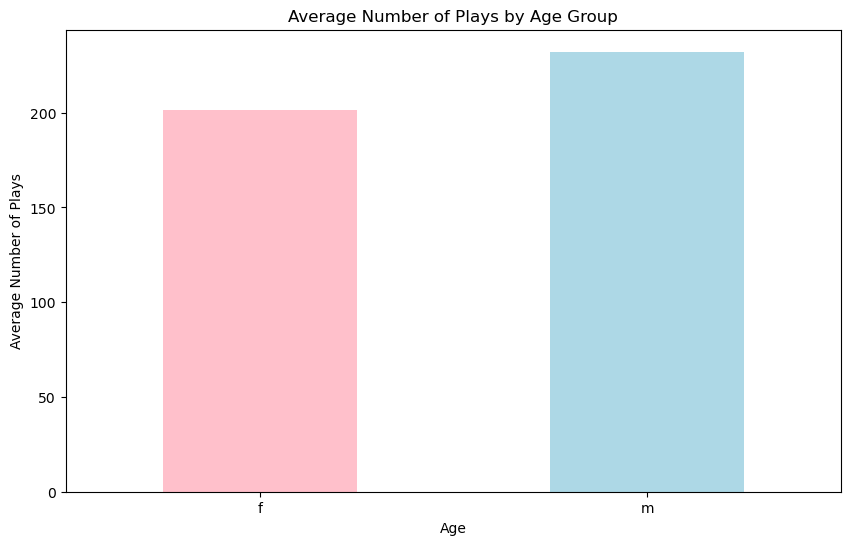

In [400]:
# Grouping by age group and calculating the average number of plays
gender_group_bucket = rec_data.groupby('gender')['plays'].mean()
colors = ['pink', 'lightblue']

# Plotting the data
plt.figure(figsize=(10,6))
gender_group_bucket.plot(kind='bar', color=colors)
plt.xlabel('Age')
plt.ylabel('Average Number of Plays')
plt.title('Average Number of Plays by Age Group')
plt.xticks(rotation=0)
plt.show()

In [401]:
rec_data.value_counts('age_group')

age_group
20-29    4650
10-19    1653
30-39    1191
40-49     271
50-59      88
0-9        35
60-69      20
90-99       6
70-79       5
80-89       3
Name: count, dtype: int64

The below cell proves our hypothesis that (some) users are lying about their age...

In [402]:
rec_data['age'].max()

121.0

# Suliman-Keshavarz-Beggs Algorithm

$$\text{rating(track, user)} = \text{max}(1, \text{min}(5, (\lfloor \frac{\text{num. plays(track)}}{\text{avg. plays}} \cdot 5) - k \cdot (\frac{\text{last signup date} - \text{signup date(user)}}{\text{last signup date}}) \rfloor))$$

We establish an algorithm to convert number of plays to a rating between 0 and 5 based on associating greater number of plays with greater song enjoyment, with the rating being proportional to the average number of plays recorded in the dataset. We use a weighting factor $k$ to minimize the influence of signing up earlier to the platform on a given user's ratings, as this may have resulted in some users having more opportunity to have their plays recorded in the dataset. We round down to the nearest whole number and take the max between this score and $1$ to negate the possibility of a negative or zero rating.

In [403]:
def suliman_keshavarz(data, k=0.05):
    return round(max(1, min(5, ((data['plays'] / avg_plays) * 5)) - k * ((last_date - data['signupDate']) / last_date)))

We develop our ratings minus the outlier so as to not bias high ratings

In [404]:
rec_data['rating'] = rec_data_copy.apply(suliman_keshavarz, axis = 1)

In [405]:
rec_data.head()

,Unnamed: 0,userId,artistId,artist,plays,gender,age,country,signupDate,age_group,rating
0,249130,03b9c645bc4f578ea1dcb6a975e7ea71fab79da2,a16371b9-7d36-497a-a9d4-42b0a0440c5e,slowdive,108,m,28.0,Germany,20060916,20-29,2.0
1,16103327,ee48ac7de691d31176a2843d0f2f8f49cab78e6d,5a24bc1a-c093-4a82-84ed-8d7f2da0570d,skinny puppy,407,m,NaN,Canada,20061214,NaN,5.0
2,12079167,b2e3d27a00fc3035edb439b14e6d30bcb6dddf69,68f1175b-592b-4f28-ab1c-85c7a438c636,turbonegro,91,m,29.0,United Kingdom,20050923,20-29,2.0
3,12210583,b4d4909255dc5bb404ff64866cac60164b465e9a,cfd3727e-7162-4e6a-a3f7-a59343ee6b8d,honey is cool,50,NaN,NaN,Denmark,20081222,NaN,1.0
4,7937614,758de8850b5a07875da1e23296e4021574be8596,3bb24e11-821a-4e4e-bd89-e0a2452474cf,useless id,108,m,25.0,Serbia,20090315,20-29,2.0


In [406]:
rec_data['rating'].value_counts()

rating
1.0    4015
5.0    2849
2.0    1400
3.0    1006
4.0     729
Name: count, dtype: int64

## Alternative Rating Algorithm

It seemed assumptive to relate the number of plays a user has on an artist to the the user's preference for that artist without taking into account how much the user listens to music. For example, the average number of plays a user has on a given artist may be 100, while a user has 50 plays for their favorite artist because they do not listen to music very often. To control for this we would estimate the plays per day a user has on a given artist by dividing the number of plays by the total days a user has been signed up. However, using this method we would assume the date the data was taken is the day after that last user to sign up. We scratched this model as it would be more assumptive than our original. We also decided that it would be most beneficial for the model to reward plays, because objectively the app is looking for retention, not how perfectly it can match users to favorite artists.
****

# DATA CLEANING

Let's reshape our dataset into a more suitable form for designing a recommender system. First we want to assign every user to every artist in our dataset.

## Computational Lightening

For computational reasons, we are going to split our dataset into different age bins, and then form multiple recommender systems based on different age groups. As an example, we will do our own age cohort, 20-29 year olds who are among the most prominent consumers of music and most likely to be 'trustworthy' data (see above for explanation). The following cell can be easily changed to develop a recommender system for any age group.

In [407]:
rec_data['age_group'] = pd.cut(rec_data['age'], bins=range(0, 101, 10), right=False, labels=[f"{i}-{i+9}" for i in range(0, 100, 10)])

In [408]:
rec_data.head()

,Unnamed: 0,userId,artistId,artist,plays,gender,age,country,signupDate,age_group,rating
0,249130,03b9c645bc4f578ea1dcb6a975e7ea71fab79da2,a16371b9-7d36-497a-a9d4-42b0a0440c5e,slowdive,108,m,28.0,Germany,20060916,20-29,2.0
1,16103327,ee48ac7de691d31176a2843d0f2f8f49cab78e6d,5a24bc1a-c093-4a82-84ed-8d7f2da0570d,skinny puppy,407,m,NaN,Canada,20061214,NaN,5.0
2,12079167,b2e3d27a00fc3035edb439b14e6d30bcb6dddf69,68f1175b-592b-4f28-ab1c-85c7a438c636,turbonegro,91,m,29.0,United Kingdom,20050923,20-29,2.0
3,12210583,b4d4909255dc5bb404ff64866cac60164b465e9a,cfd3727e-7162-4e6a-a3f7-a59343ee6b8d,honey is cool,50,NaN,NaN,Denmark,20081222,NaN,1.0
4,7937614,758de8850b5a07875da1e23296e4021574be8596,3bb24e11-821a-4e4e-bd89-e0a2452474cf,useless id,108,m,25.0,Serbia,20090315,20-29,2.0


In [409]:
rec_data_zoom = rec_data[rec_data['age_group'] == '20-29']

In [410]:
rec_data_zoom.head()

,Unnamed: 0,userId,artistId,artist,plays,gender,age,country,signupDate,age_group,rating
0,249130,03b9c645bc4f578ea1dcb6a975e7ea71fab79da2,a16371b9-7d36-497a-a9d4-42b0a0440c5e,slowdive,108,m,28.0,Germany,20060916,20-29,2.0
2,12079167,b2e3d27a00fc3035edb439b14e6d30bcb6dddf69,68f1175b-592b-4f28-ab1c-85c7a438c636,turbonegro,91,m,29.0,United Kingdom,20050923,20-29,2.0
4,7937614,758de8850b5a07875da1e23296e4021574be8596,3bb24e11-821a-4e4e-bd89-e0a2452474cf,useless id,108,m,25.0,Serbia,20090315,20-29,2.0
5,10177216,96902533dbad7baa634adf7e082403a58f562ed8,82caaf3a-76de-4604-a71d-5072ea20534f,murat boz,4,f,20.0,Poland,20090214,20-29,1.0
6,10159771,964ce203def2358599a79a26d23a0ae6d3365e93,1c70a3fc-fa3c-4be1-8b55-c3192db8a884,röyksopp,3945,m,20.0,Germany,20080902,20-29,5.0


In [411]:
# dimensions check out
rec_data_zoom.shape

(4650, 11)

In [412]:
rec_data_zoom = rec_data_zoom.sort_values(by='artist')

In [413]:
ratings = rec_data_zoom[['userId', 'rating', 'artist']]

In [414]:
unique_users = rec_data_zoom['userId'].unique()
unique_artists = rec_data_zoom['artist'].unique()

In [415]:
user_artist_combinations = pd.DataFrame([(artist, user) for artist in unique_artists for user in unique_users],
                                        columns=['artist', 'userId'])

In [416]:
user_artist_combinations.head()

,artist,userId
0,!!!,4fb83e93ec1e10ef97e67fc6d912fb7e778339be
1,!!!,0b749f78e378d5212a95919d13835335e2c7c55d
2,!!!,9901740c9c7ba5ac45bfa4e044d7aff496b1fbab
3,!!!,36049eca9ae1a1deea28977ec092217059cd0cfe
4,!!!,116a6146a2336eb0ec59a71d4ea3149967ed11b3


Now let's create a dataset of corresponding information for each unique user in our dataset.

In [417]:
gender_list = []
age_list = []
country_list = []
for user_id in unique_users:
    gender_list.append(rec_data_zoom[rec_data_zoom['userId'] == user_id]['gender'].values[0])
    age_list.append(rec_data_zoom[rec_data_zoom['userId'] == user_id]['age'].values[0])
    country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  country_list.append(rec_data_zoom[rec_data['userId'] == user_id]['country'].values[0])
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3805329367.py:7: UserW

In [418]:
unique_users = pd.DataFrame(unique_users)
unique_users['Gender'] = gender_list
unique_users['Age'] = age_list
unique_users['Country'] = country_list

unique_users = unique_users.rename(columns={0: 'userId'})

In [419]:
unique_users.head()

,userId,Gender,Age,Country
0,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom
1,0b749f78e378d5212a95919d13835335e2c7c55d,NaN,20.0,Russian Federation
2,9901740c9c7ba5ac45bfa4e044d7aff496b1fbab,m,24.0,Russian Federation
3,36049eca9ae1a1deea28977ec092217059cd0cfe,f,20.0,Netherlands
4,116a6146a2336eb0ec59a71d4ea3149967ed11b3,m,21.0,Netherlands


And now we merge the two dataframes together on the user ID column, creating a merged dataframe of every artist associated with every user, and the corresponding user information.

In [420]:
merged_data = pd.merge(user_artist_combinations, unique_users, on='userId')

In [421]:
merged_data.head()

,artist,userId,Gender,Age,Country
0,!!!,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom
1,#####,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom
2,*nsync,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom
3,...and you will know us by the trail of dead,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom
4,10 years,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom


Now we merge our ratings dataframe with the full dataframe of user-artist combinations. Then we drop the user ratings for the artists that user did not actually listen to and replace them with NA values.

In [422]:
training_df = pd.merge(merged_data, ratings, on='userId', how='inner')

In [423]:
training_df.head()

,artist_x,userId,Gender,Age,Country,rating,artist_y
0,!!!,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom,1.0,!!!
1,#####,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom,1.0,!!!
2,*nsync,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom,1.0,!!!
3,...and you will know us by the trail of dead,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom,1.0,!!!
4,10 years,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,m,26.0,United Kingdom,1.0,!!!


In [424]:
unique_user_artist_plays = ratings.groupby(['userId', 'artist'])['rating'].sum().reset_index()

# Merge merged_data with unique_user_artist_plays
training_df = pd.merge(merged_data, unique_user_artist_plays, on=['userId', 'artist'], how='left')

# Replace NaN values (where user hasn't listened to a specific artist) with 0
#training_df['rating'].fillna(0, inplace=True)

In [425]:
training_df.columns

Index(['artist', 'userId', 'Gender', 'Age', 'Country', 'rating'], dtype='object')

In [426]:
ratings_df = training_df.drop(columns=['Gender', 'Age', 'Country'])

In [427]:
ratings_df.head()

,artist,userId,rating
0,!!!,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,1.0
1,#####,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,NaN
2,*nsync,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,NaN
3,...and you will know us by the trail of dead,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,NaN
4,10 years,4fb83e93ec1e10ef97e67fc6d912fb7e778339be,NaN


Set multiindex on artist, followed by user ID columns.

In [428]:
ratings_df.set_index('artist', inplace=True)
ratings_df.set_index('userId', append=True, inplace=True)

In [429]:
R_all = ratings_df.unstack(['userId'])
R_all

rating  \
userId                                       001a92a006061452ea53cadf1f1e1db985f3a51f   
artist                                                                                  
!!!                                                                               NaN   
#####                                                                             NaN   
*nsync                                                                            NaN   
...and you will know us by the trail of dead                                      NaN   
10 years                                                                          NaN   
...                                                                               ...   
zombie nation                                                                     NaN   
zz top                                                                            NaN   
Çileke?                                                                           NaN   
Édith piaf                                                                        NaN   
Überzone                                                                          NaN   

                                                                                       \
userId                                       0073e9df704415e9d72f75380ba88059fca4230a   
artist                                                                                  
!!!                                                                               NaN   
#####                                                                             NaN   
*nsync                                                                            NaN   
...and you will know us by the trail of dead                                      NaN   
10 years                                                                          NaN   
...                                                                               ...   
zombie nation                                                                     NaN   
zz top                                                                            NaN   
Çileke?                                                                           NaN   
Édith piaf                                                                        NaN   
Überzone                                                                          NaN   

                                                                                       \
userId                                       00a29f324b17156f3a1acc1485321054d7a3c823   
artist                                                                                  
!!!                                                                               NaN   
#####                                                                             NaN   
*nsync                                                                            NaN   
...and you will know us by the trail of dead                                      NaN   
10 years                                                                          NaN   
...                                                                               ...   
zombie nation                                                                     NaN   
zz top                                                                            NaN   
Çileke?                                                                           NaN   
Édith piaf                                                                        NaN   
Überzone                                                                          NaN   

                                                                                       \
userId                                       00a9202028ec7d12c676f727f9a1740c20d4251f   
artist                                                                                  
!!!                                                                    

In [430]:
I = 15
M = 15

# retrieve music/users combination that is not *too* sparse
top_artists = R_all.agg('sum', axis=1).nlargest(10).tail(M).index
top_10_artists_list = R_all.agg('sum', axis=1).nlargest(10)
top_users = R_all.loc[list((top_10_artists_list).index)].notna().any()

R = R_all.loc[top_artists, top_users]
R

rating  \
userId           06650d54d303c884258001e7669216ef35f70610   
artist                                                      
radiohead                                             NaN   
the beatles                                           NaN   
coldplay                                              NaN   
the cure                                              NaN   
pink floyd                                            NaN   
system of a down                                      NaN   
foo fighters                                          NaN   
rammstein                                             NaN   
sigur rós                                             5.0   
arctic monkeys                                        NaN   

                                                           \
userId           08e69dc29b28e895943386fb3e91ee007b932787   
artist                                                      
radiohead                                             NaN   
the beatles                                           NaN   
coldplay                                              NaN   
the cure                                              4.0   
pink floyd                                            NaN   
system of a down                                      NaN   
foo fighters                                          NaN   
rammstein                                             NaN   
sigur rós                                             NaN   
arctic monkeys                                        NaN   

                                                           \
userId           0d2c2fc3c9bbaf0fc952e099a52f0f532b643ac9   
artist                                                      
radiohead                                             NaN   
the beatles                                           NaN   
coldplay                                              NaN   
the cure                                              NaN   
pink floyd                                            NaN   
system of a down                                      NaN   
foo fighters                                          NaN   
rammstein                                             5.0   
sigur rós                                             NaN   
arctic monkeys                                        NaN   

                                                           \
userId           0e49ec74c38a793423ff04e03e645132312a71c5   
artist                                                      
radiohead                                             NaN   
the beatles                                           NaN   
coldplay                                              NaN   
the cure                                              NaN   
pink floyd                                            NaN   
system of a down                                      NaN   
foo fighters                                          NaN   
rammstein                                             NaN   
sigur rós                                             1.0   
arctic monkeys                                        NaN   

                                                           \
userId           0e5fe03f6434402eb27122260b579417968fc217   
artist                                                      
radiohead                                             NaN   
the beatles                                           NaN   
coldplay                                              NaN   
the cure                                              5.0   
pink floyd                                            NaN   
system of a down                                      NaN   
foo fighters                                          NaN   
rammstein                                             NaN   
sigur rós                                             NaN   
arctic monkeys                                        NaN   

                                                           \
userId           10f

In [431]:
R_all.shape

(2881, 4597)

In [432]:
(np.isnan(R_all)).mean().mean()

0.9996488964740674

We have a very sparse dataset.

In [433]:
R_all_filled = R_all.fillna(0)
(R_all_filled != 0).sum(axis = 0).value_counts()

1    4544
2      51
0       1
3       1
Name: count, dtype: int64

It seems that the overwhelming majority of users have only one artist that they've listened to, making it difficult to form a recommendation system.

## User and Music Matrices

Model rating $r_{mi}$ of movie $m$ by user $i$:
$$ \hat r_{mi} = \sum_{k=1}^K v_{mk} u_{ik} = v_{m} u_{i}^T $$
* $K$ unobserved characteristics (latent factors)
* $v_m=(v_{m1},\dots,v_{mK})$: movie $m$ having characteristic $k=1,\dots,K$
* $u_i=(u_{i1},\dots,u_{iK})$: user $i$'s affinity to characteristic $k=1,\dots,K$
* Rating $r_{mi}$ is high if $v_m$ and $u_i$ are well-aligned

We want to find the optimal number of latent factors $k$ on which to apply this.

## Outline

We will trial-and-error several different ways to optimize $k$.

1. SVD after imputing mean for missing values, threshhold on amount of variance 
2. Use cross-validation across several values for $k$, then choose the one that reduces the RMSE the most, post-gradient descent

## SVD

Since our dataframe is so sparse, we want to use a more clever method for imputing values. We use the following formula to impute missing values per row:
$$\text{impute value(row)} = \text{mean} +/- \frac{\text{mean(row)}}{\text{bias} \cdot \text{mean}}$$
We add or subtract the biased term depending on whether the row mean is greater or lower than the overall mean. This is because artists who receive high/low ratings should be inputted values from existing users should be imputted values that reflect this. The bias term determines how much we want to weigh the effect of existing ratings. Since our dataset is so sparse, and the ratings were only implicitly created from the existing data using the Suliman-Keshavarz algorithm, we want a high bias to lessen the effect of our ratings on the imputation. The minimum possible value is bias $= 1$, since otherwise we can recieve imputations greater than the maximum rating of $5$. 

In [434]:
def imputer(data, bias=3):
    data2 = data.copy()
    mean_value = np.nanmean(R_all.values)
    for i, row in data.iterrows():
        if row.mean() > mean_value:
            imput_val = mean_value + (row.mean() / (bias * mean_value))
        elif row.mean() < mean_value:
            imput_val = mean_value - (row.mean() / (bias * mean_value))
        data2.loc[i] = data2.loc[i].fillna(imput_val)
    return data2

In [435]:
# Fill NaN values using imputer function
R_all3 = imputer(R_all)

In [436]:
R_all3

rating  \
userId                                       001a92a006061452ea53cadf1f1e1db985f3a51f   
artist                                                                                  
!!!                                                                          2.784834   
#####                                                                        3.244638   
*nsync                                                                       2.784834   
...and you will know us by the trail of dead                                 2.669883   
10 years                                                                     2.669883   
...                                                                               ...   
zombie nation                                                                3.474540   
zz top                                                                       3.474540   
Çileke?                                                                      2.784834   
Édith piaf                                                                   3.474540   
Überzone                                                                     2.784834   

                                                                                       \
userId                                       0073e9df704415e9d72f75380ba88059fca4230a   
artist                                                                                  
!!!                                                                          2.784834   
#####                                                                        3.244638   
*nsync                                                                       2.784834   
...and you will know us by the trail of dead                                 2.669883   
10 years                                                                     2.669883   
...                                                                               ...   
zombie nation                                                                3.474540   
zz top                                                                       3.474540   
Çileke?                                                                      2.784834   
Édith piaf                                                                   3.474540   
Überzone                                                                     2.784834   

                                                                                       \
userId                                       00a29f324b17156f3a1acc1485321054d7a3c823   
artist                                                                                  
!!!                                                                          2.784834   
#####                                                                        3.244638   
*nsync                                                                       2.784834   
...and you will know us by the trail of dead                                 2.669883   
10 years                                                                     2.669883   
...                                                                               ...   
zombie nation                                                                3.474540   
zz top                                                                       3.474540   
Çileke?                                                                      2.784834   
Édith piaf                                                                   3.474540   
Überzone                                                                     2.784834   

                                                                                       \
userId                                       00a9202028ec7d12c676f727f9a1740c20d4251f   
artist                                                                                  
!!!                                                                    

## User and Movies Matrices

Model rating $r_{mi}$ of movie $m$ by user $i$:
$$ \hat r_{mi} = \sum_{k=1}^K v_{mk} u_{ik} = v_{m} u_{i}^T $$
* $K$ unobserved characteristics (latent factors)
* $v_m=(v_{m1},\dots,v_{mK})$: movie $m$ having characteristic $k=1,\dots,K$
* $u_i=(u_{i1},\dots,u_{iK})$: user $i$'s affinity to characteristic $k=1,\dots,K$
* Rating $r_{mi}$ is high if $v_m$ and $u_i$ are well-aligned

$U$ and $V$ as matrix factors

$$
\begin{aligned}
&\min_{U,V} \|R - V U^T\|_F^2
\end{aligned}
$$

- Ratings matrix $R$: size $M\times I$ 
- Movies matrix $V$: size $M\times K$
- Users matrix $U$: size  $I\times K$

We use SVD to decompose a manageable subset of the dataset

In [437]:
# Take manageable subset of our data
I = 300
M = 300

R_all5 = R_all3.iloc[:M, :I]

Here is an example of how the SVD works

In [438]:
u, s, vh = np.linalg.svd(R_all5, full_matrices=False)

threshold = 0.1

# Retain singular values greater than the threshold
selected_singular_values = s[s > threshold]

In [439]:
# Indices of selected singular values
indices = np.where(s > threshold)[0]

# Collect U and V based on retained singular values
U = u[:, indices]
V = vh[indices, :].T

In [440]:
print(U.shape)

(300, 32)


In [441]:
print(V.shape)

(300, 32)


In [442]:
(R_all5)

rating  \
userId                                       001a92a006061452ea53cadf1f1e1db985f3a51f   
artist                                                                                  
!!!                                                                          2.784834   
#####                                                                        3.244638   
*nsync                                                                       2.784834   
...and you will know us by the trail of dead                                 2.669883   
10 years                                                                     2.669883   
...                                                                               ...   
bear mccreary                                                                3.244638   
beastie boys                                                                 3.340431   
beatdrop                                                                     3.359589   
beatsteaks                                                                   3.244638   
beaver                                                                       2.669883   

                                                                                       \
userId                                       0073e9df704415e9d72f75380ba88059fca4230a   
artist                                                                                  
!!!                                                                          2.784834   
#####                                                                        3.244638   
*nsync                                                                       2.784834   
...and you will know us by the trail of dead                                 2.669883   
10 years                                                                     2.669883   
...                                                                               ...   
bear mccreary                                                                3.244638   
beastie boys                                                                 3.340431   
beatdrop                                                                     3.359589   
beatsteaks                                                                   3.244638   
beaver                                                                       2.669883   

                                                                                       \
userId                                       00a29f324b17156f3a1acc1485321054d7a3c823   
artist                                                                                  
!!!                                                                          2.784834   
#####                                                                        3.244638   
*nsync                                                                       2.784834   
...and you will know us by the trail of dead                                 2.669883   
10 years                                                                     2.669883   
...                                                                               ...   
bear mccreary                                                                3.244638   
beastie boys                                                                 3.340431   
beatdrop                                                                     3.359589   
beatsteaks                                                                   3.244638   
beaver                                                                       2.669883   

                                                                                       \
userId                                       00a9202028ec7d12c676f727f9a1740c20d4251f   
artist                                                                                  
!!!                                                                    

In [443]:
from numpy import sqrt, mean

# calculate RMSE
def rmse(X, Y):
    return sqrt(mean((X - Y)**2))
error = [(0, rmse(R_all5.T, np.inner(V,U)))]

In [444]:
print(error)

[(0, 3.0771748739417397)]


This is a high degree of error. We now iterate through different sizes of the SVD to optimize for error and computability

In [445]:
# iterate through different thresholds
import time
max_iterations = 40  # maximum number of iterations
U, S, V = np.linalg.svd(R_all5, full_matrices=False)

In [446]:
print(S.shape)

(300,)


In [447]:
error = []

for t in range(1, max_iterations):
    threshold = 10 / t    
    
    # Indices of selected singular values
    indices = np.where(S > threshold)[0]
    S1 = np.diag(S[indices])

    # Collect U and V based on retained singular values
    U1 = U[:, indices]
    V1 = V[indices, :]
    
    Q1 = np.matmul(U1, np.sqrt(S1))
    W1 = np.matmul(np.sqrt(S1), V1)
    print('threshold: ', threshold)
    print('Q1 shape: ', Q1.shape)
    print('W1 shape: ', W1.shape)
    print('RMSE', rmse(R_all5['rating'], np.matmul(Q1, W1)))
    # compute error after one sweep of updates
    error += [(threshold, rmse(R_all5['rating'], np.matmul(Q1, W1)))]
    
error = pd.DataFrame(error, columns=['threshold', 'rmse'])

threshold:  10.0
Q1 shape:  (300, 1)
W1 shape:  (1, 300)
RMSE 0.02906747036677289
threshold:  5.0
Q1 shape:  (300, 1)
W1 shape:  (1, 300)
RMSE 0.02906747036677289
threshold:  3.3333333333333335
Q1 shape:  (300, 1)
W1 shape:  (1, 300)
RMSE 0.02906747036677289
threshold:  2.5
Q1 shape:  (300, 3)
W1 shape:  (3, 300)
RMSE 0.02610195815098946
threshold:  2.0
Q1 shape:  (300, 7)
W1 shape:  (7, 300)
RMSE 0.021216055444923332
threshold:  1.6666666666666667
Q1 shape:  (300, 14)
W1 shape:  (14, 300)
RMSE 0.014392723437109923
threshold:  1.4285714285714286
Q1 shape:  (300, 19)
W1 shape:  (19, 300)
RMSE 0.008588641229801876
threshold:  1.25
Q1 shape:  (300, 20)
W1 shape:  (20, 300)
RMSE 0.007421279409585921
threshold:  1.1111111111111112
Q1 shape:  (300, 20)
W1 shape:  (20, 300)
RMSE 0.007421279409585921
threshold:  1.0
Q1 shape:  (300, 20)
W1 shape:  (20, 300)
RMSE 0.007421279409585921
threshold:  0.9090909090909091
Q1 shape:  (300, 20)
W1 shape:  (20, 300)
RMSE 0.007421279409585921
threshold:  0

As the dimensions of our reduced SVD approach the full dimensions of the original matrix, error will tend to zero. We want to choose a threshold for the size of our reduced SVD that will minimize error while also being computationally efficient by being as small as possible. While examining the above error rates, we heuristically choose a threshold of $\frac{5}{3}$. 

In [448]:
u, s, vh = np.linalg.svd(R_all5, full_matrices=False)

threshold = 5/3

# Retain singular values greater than the threshold
selected_singular_values = s[s > threshold]

In [449]:
# Indices of selected singular values
indices = np.where(s > threshold)[0]

# Collect U and V based on retained singular values
U = u[:, indices]
V = vh[indices, :].T

In [450]:
print(f'U Shape: {U.shape}')
print(f'V Shape: {V.shape}')

U Shape: (300, 14)
V Shape: (300, 14)


So: $$k = 14$$

Now we will attempt cross validation instead as a way of choosing $k$.

## Cross Validation

In [451]:
def imputer(data, bias=3):
    data2 = data.copy()
    mean_value = np.nanmean(R_all.values)
    for i, row in data.iterrows():
        if row.mean() > mean_value:
            imput_val = mean_value + (row.mean() / (bias * mean_value))
        elif row.mean() < mean_value:
            imput_val = mean_value - (row.mean() / (bias * mean_value))
        data2.loc[i] = data2.loc[i].fillna(imput_val)
    return data2

In [452]:
# Fill NaN values using imputer function
R_all4 = imputer(R_all)

In [453]:
R_all4

rating  \
userId                                       001a92a006061452ea53cadf1f1e1db985f3a51f   
artist                                                                                  
!!!                                                                          2.784834   
#####                                                                        3.244638   
*nsync                                                                       2.784834   
...and you will know us by the trail of dead                                 2.669883   
10 years                                                                     2.669883   
...                                                                               ...   
zombie nation                                                                3.474540   
zz top                                                                       3.474540   
Çileke?                                                                      2.784834   
Édith piaf                                                                   3.474540   
Überzone                                                                     2.784834   

                                                                                       \
userId                                       0073e9df704415e9d72f75380ba88059fca4230a   
artist                                                                                  
!!!                                                                          2.784834   
#####                                                                        3.244638   
*nsync                                                                       2.784834   
...and you will know us by the trail of dead                                 2.669883   
10 years                                                                     2.669883   
...                                                                               ...   
zombie nation                                                                3.474540   
zz top                                                                       3.474540   
Çileke?                                                                      2.784834   
Édith piaf                                                                   3.474540   
Überzone                                                                     2.784834   

                                                                                       \
userId                                       00a29f324b17156f3a1acc1485321054d7a3c823   
artist                                                                                  
!!!                                                                          2.784834   
#####                                                                        3.244638   
*nsync                                                                       2.784834   
...and you will know us by the trail of dead                                 2.669883   
10 years                                                                     2.669883   
...                                                                               ...   
zombie nation                                                                3.474540   
zz top                                                                       3.474540   
Çileke?                                                                      2.784834   
Édith piaf                                                                   3.474540   
Überzone                                                                     2.784834   

                                                                                       \
userId                                       00a9202028ec7d12c676f727f9a1740c20d4251f   
artist                                                                                  
!!!                                                                    

In [454]:
# Find the indices of where the non NaN values were located
nonnull_indices = pd.DataFrame(np.transpose(np.where(R_all != None)))

In [455]:
nonnull_indices.columns = ['x', 'y']

In [456]:
len(nonnull_indices['x'])

13243957

In [457]:
unique_values = nonnull_indices['x'].unique()

In [458]:
len(unique_values)

2881

In [459]:
# Count occurrences of values in the first column
counts = nonnull_indices['x'].value_counts()

# Filter the DataFrame to include only the users who have multiple ratings across artists
nonnull_indices2 = nonnull_indices[nonnull_indices['x'].isin(counts[counts > 1].index)]

In [460]:
print(counts)

x
0       4597
1914    4597
1916    4597
1917    4597
1918    4597
        ... 
962     4597
963     4597
964     4597
965     4597
2880    4597
Name: count, Length: 2881, dtype: int64


In [461]:
print(nonnull_indices2.head())

   x  y
0  0  0
1  0  1
2  0  2
3  0  3
4  0  4


In [462]:
print(len(nonnull_indices2))

13243957


In [463]:
R_all4.iloc[1, 394]

3.2446381055364704

In [464]:
duplicate_mask = nonnull_indices2.duplicated(subset='x', keep='first') & nonnull_indices2.duplicated(subset='x', keep=False)
nonnull_indices2 = nonnull_indices2[~duplicate_mask]

We will use leave-one-out cross validation to optimize the size of our non-negative matrix factorization. Now that we have identified the non-null indices of those artists who have multiple listeners in our dataframe, we will systematically iterate through this list for each potential choice of $k$ (from $3-10$, in line with the literature on recommender systems), and leave out a rating for this artist before performing the matrix factorization. We then take the dot product of the relevant artist row in $W$ and user column in $H$ to predict the missing value, and sum up the prediction error for every missing value across a single choice of $k$. We choose the value of $k$ associated with the lowest PRESS value (predicted residual sum of squares).

For computational reasons (explained below), we artificially cut off the number of iterations at 20 for each value of $k$ to get an overall sense of how different values of $k$ affect prediction error.

In [465]:
# this will take some time... have patience, it will run :)
# leave-one-out cross validation
from sklearn.decomposition import NMF
for k in range(3,10):
    PRESS = 0
    num_iter = 0
    for x_value in nonnull_indices2['x']:
        num_iter += 1
        y_value = nonnull_indices2[nonnull_indices2['x'] == x_value]['y'].iloc[0]
        remove_coord = (x_value, y_value)
        R_cross_validated = R_all4[~R_all4.index.isin(remove_coord)]
        model = NMF(n_components=k, init='random', random_state=0)
        # Fit the model to the data
        W = model.fit_transform(R_cross_validated)  # Matrix of basis vectors (components)
        H = model.components_          # Matrix of coefficients
        predicted_value = np.dot(W[x_value], H[:, y_value])
        PRESS += np.abs(predicted_value - R_all4.iloc[x_value, y_value])
        print('(k value, PRESS): ', (k, PRESS))
        print('predicted value: ', predicted_value)
        if num_iter >= 20:
            break

(k value, PRESS):  (3, 0.00017780665565947373)
predicted value:  2.7850116997922485
(k value, PRESS):  (3, 0.0036161989951555285)
predicted value:  3.2480764978759664
(k value, PRESS):  (3, 0.006335293044600565)
predicted value:  2.782114799087144
(k value, PRESS):  (3, 0.00670731318453166)
predicted value:  2.6702548601765494
(k value, PRESS):  (3, 0.006782622050588216)
predicted value:  2.669958148902675
(k value, PRESS):  (3, 0.006971835192262521)
predicted value:  2.7850231062782633
(k value, PRESS):  (3, 0.0077844469314567455)
predicted value:  3.475352823475605
(k value, PRESS):  (3, 0.008469763731856261)
predicted value:  3.4738548949360113
(k value, PRESS):  (3, 0.009572304479039673)
predicted value:  3.4734376709892274
(k value, PRESS):  (3, 0.011675784168542425)
predicted value:  3.2425346258469676
(k value, PRESS):  (3, 0.013510127493385315)
predicted value:  3.4763745550612537
(k value, PRESS):  (3, 0.01583947741070535)
predicted value:  3.2423087556191503
(k value, PRESS):

(k value, PRESS):  (8, 0.005407232428842335)
predicted value:  3.2483741250127394
(k value, PRESS):  (8, 0.0071580266832245165)
predicted value:  2.783083098882207
(k value, PRESS):  (8, 0.00795589808136521)
predicted value:  2.670680711434759
(k value, PRESS):  (8, 0.007958376193784478)
predicted value:  2.6698853181490376
(k value, PRESS):  (8, 0.008032859412828941)
predicted value:  2.7849083763556335
(k value, PRESS):  (8, 0.009123832982722568)
predicted value:  3.4756311853063044
(k value, PRESS):  (8, 0.009704239283995442)
predicted value:  3.4751206180376837
(k value, PRESS):  (8, 0.009905298631788462)
predicted value:  3.474741271084204
(k value, PRESS):  (8, 0.013336629712062287)
predicted value:  3.2412067744561965
(k value, PRESS):  (8, 0.015396919918806873)
predicted value:  3.4766005019431554
(k value, PRESS):  (8, 0.01922745161068029)
predicted value:  3.240807573844597
(k value, PRESS):  (8, 0.021383547390828372)
predicted value:  2.782677797356441
(k value, PRESS):  (8,

## Building Recommender System

We choose to use SVD to optimize for k instead of leave-one-out cross validations for two reasons. The first is compuational. Since we have to recompute non-negative matrix factorization of every single nonnull index, it would take an extremely long time to finish running, even on the subset of the original rating dataset. The second reason is as we can see from our printed out predicted values across all values of $k$ is that because our original dataset is so sparse with over 99% of our values being artificially inputted the cross validation does not have enough actual data to estimate the relevance of a single data point. Hence, our predicted values are totally determined by the inputted values.

Before we performed SVD in order to optimize for number of latent factors $k$. Now we will initialize our matrix decomposition into 2 matrices, U and V. Then, we will perform gradient decent in order to minimize error and decompose our ratings matrix, R, into an optimal of users and ratings as in the formula above.

In [466]:
U.shape

(300, 14)

In [467]:
V.shape

(300, 14)

We calculate matrices $U$ and $V$ to solve the following optimization problem (if all ratings are given, or in this case artificially imputed in the case of NA values):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I I_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
I_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ are calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user. 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operations:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha\Gamma_{m-}^T v_m,
\end{aligned}
$$
where $\Gamma_{m-}$ is the $m$-th row of $\Gamma$ (use the notation $\Gamma_{-i}$ for the $i$-th column). When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

Here are our update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$
While working on this problem our team ran into some numerical stability issues, where the update values for $G$ become smaller and smaller with iteration, eventually resulting in an underflow error.

To prevent this, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I I_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|^2 + \sum_{m=1}^{M}\|v_m\|^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization. In line with the current literature, we choose $\lambda = 5$ for our purposes.

In [468]:
def update_G(R_, U_, V_):
    
    return R_ - V_ @ U_.T

def update_U(G_, U_, V_, lam=5, alpha=0.01):
    
    return U_ + 2 * alpha * (np.nan_to_num(G_.T) @ V_ - lam * U_)

def update_V(G_, U_, V_, lam=5, alpha=0.01):
    
    return V_ + 2 * alpha * (np.nan_to_num(G_) @ U_ - lam * V_)

Our metric for improvement will be
$$ \text{RMSE}(x, y) = \left[\frac{1}{n}\sum_{i=1}^{n} \|x_i - y_i\|_2^2 \right]^{1/2},$$
    where matrices $x$ and $y$ are first vectorized

In [469]:
def rmse2(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

In [470]:
def max_update(X, Y, epsilon=1e-10, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/(Y + epsilon))
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

In [243]:
def compute_UV(Rdf, K=5, alpha=0.001, max_iteration=100, diff_thr=1e-3):

    R = Rdf.values

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K) # initialize with random numbers
    V = np.random.rand(M, K) # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G, U, V, alpha=alpha)
        Gnew = update_G(R, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha=alpha)
        Gnew = update_G(R, Unew, Vnew)
        print('new V', V)
        print('new W', W)
        print('new G', G)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse2(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
  #  U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
  #  V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
np.random.seed(134) # set seed for tests
output1 = compute_UV(R_all5, K=14)

new V [[0.77326381 0.60830094 0.27728004 ... 0.76973136 0.46446877 0.43939582]
 [0.21993063 0.3680089  0.75187037 ... 0.52341575 0.2283049  0.12670637]
 [0.58225491 0.5850808  0.76519321 ... 0.10338318 0.88188189 0.35370319]
 ...
 [0.44947348 0.12131987 0.86834826 ... 0.9263014  0.01330371 0.50349321]
 [0.0331733  0.52821377 0.38241177 ... 0.23193007 0.42551554 0.97040358]
 [0.62522262 0.29539242 0.82488917 ... 0.23621254 0.88913477 0.80283117]]
new W [[1.46525175 0.75181409 0.54393783 ... 0.47688482 0.5198587  0.50955131]
 [2.15890656 1.24169147 0.80416363 ... 0.40166595 0.54503565 0.21557032]
 [1.20672389 0.54651518 0.47821585 ... 0.5301462  0.56617413 0.61452255]
 ...
 [1.50904083 0.78764578 0.53460729 ... 0.48578944 0.50591122 0.55426739]
 [2.27226331 1.29792127 0.86525752 ... 0.41837538 0.59932411 0.19143896]
 [1.14997521 0.4987642  0.39355605 ... 0.61444135 0.55194253 0.88029271]]
new G [[-0.83909177 -1.05211391 -0.40992259 ... -1.32784046 -1.48197793
  -0.61735579]
 [-0.38649826

new V [[0.41044555 0.40240763 0.27339014 ... 0.44636935 0.33904406 0.32749373]
 [0.3682715  0.40107908 0.4572606  ... 0.40548309 0.36923073 0.36452026]
 [0.34251751 0.35666697 0.40224507 ... 0.25071975 0.46975781 0.27762694]
 ...
 [0.44800666 0.33713581 0.54539166 ... 0.55065684 0.2998905  0.47122576]
 [0.28009842 0.40976129 0.35921137 ... 0.37371754 0.40574824 0.57128949]
 [0.35052297 0.28235373 0.44376718 ... 0.30147002 0.46556476 0.39655204]]
new W [[1.46525175 0.75181409 0.54393783 ... 0.47688482 0.5198587  0.50955131]
 [2.15890656 1.24169147 0.80416363 ... 0.40166595 0.54503565 0.21557032]
 [1.20672389 0.54651518 0.47821585 ... 0.5301462  0.56617413 0.61452255]
 ...
 [1.50904083 0.78764578 0.53460729 ... 0.48578944 0.50591122 0.55426739]
 [2.27226331 1.29792127 0.86525752 ... 0.41837538 0.59932411 0.19143896]
 [1.14997521 0.4987642  0.39355605 ... 0.61444135 0.55194253 0.88029271]]
new G [[ 0.02530651  0.01292631  0.04475922 ...  0.01156548  0.02063156
   0.0228518 ]
 [-0.07306493

In [471]:
output1['U']

array([[0.52069749, 0.46440849, 0.47783473, ..., 0.40406009, 0.42069021,
        0.53227104],
       [0.45328453, 0.47604761, 0.444458  , ..., 0.45258984, 0.51785915,
        0.47957452],
       [0.36192932, 0.42114831, 0.53727591, ..., 0.56610677, 0.41813922,
        0.46026957],
       ...,
       [0.4603841 , 0.50905681, 0.42954061, ..., 0.53910302, 0.47061546,
        0.4102506 ],
       [0.42239317, 0.47981808, 0.47914127, ..., 0.49678556, 0.39180945,
        0.41653802],
       [0.46884584, 0.41931895, 0.41660506, ..., 0.44591022, 0.47935334,
        0.51166735]])

This matrix usually represents the "user" factors. Each row in matrix $U$ corresponds to a user, and the columns represent latent factors that characterize the users' preferences. These latent factors are not explicitly defined but are derived from the ratings data during the matrix factorization process.

In [472]:
output1['V']

array([[0.44756811, 0.45011616, 0.36535063, ..., 0.48663987, 0.4077204 ,
        0.40359968],
       [0.45202641, 0.47687003, 0.50185216, ..., 0.48025523, 0.45903852,
        0.45169071],
       [0.4039968 , 0.41814569, 0.44685679, ..., 0.36195782, 0.49335683,
        0.3688502 ],
       ...,
       [0.51336046, 0.44310609, 0.57607152, ..., 0.58966399, 0.42101138,
        0.53406921],
       [0.39200176, 0.47230756, 0.43890924, ..., 0.4675574 , 0.47875591,
        0.57890445],
       [0.40069547, 0.3623523 , 0.46700285, ..., 0.38659105, 0.48100955,
        0.43400718]])

This matrix generally represents the "item" factors, where each row corresponds to an artist, and the columns are again latent factors. These factors capture characteristics of the artists.

## Ratings

Comparison Data Frame:
* `observed`: observed ratings , $R$
* `fit`: calculated ratings $\hat r_{mi}$  if $r_{mi}$ is observed
* `fit/prediction`: $\hat R = VU^T$
* `deviation`: $(\hat r_{mi} - r_{mi})$

In [473]:
np.inner(V, U)

array([[0.00301909, 0.00042774, 0.00301909, ..., 0.0036422 , 0.00351758,
        0.00289447],
       [0.00301909, 0.00042774, 0.00301909, ..., 0.0036422 , 0.00351758,
        0.00289447],
       [0.00301909, 0.00042774, 0.00301909, ..., 0.0036422 , 0.00351758,
        0.00289447],
       ...,
       [0.00301909, 0.00042774, 0.00301909, ..., 0.0036422 , 0.00351758,
        0.00289447],
       [0.00301909, 0.00042774, 0.00301909, ..., 0.0036422 , 0.00351758,
        0.00289447],
       [0.00301909, 0.00042774, 0.00301909, ..., 0.0036422 , 0.00351758,
        0.00289447]])

Unfortunately, there is a fundamental issue in our dataset that makes gradient descent extremely challenging to perform. Because our dataset was so sparse, we were forced to impute values before factorizing. However, even despite our clever method of imputation we still run into the problem of collinearity, since the same imputed value is being repeated across the entire dataset, our columns are all highly correlated. After experimenting with lots of different values for our regularization penalty $\lambda$, our step size $\alpha$, and our initialization of $U, V$, we were able to successfully prevent the stability issue leading to underflow errors but unable to ensure convergence. As an alternative, we will scale our fit/prediction values to ensure that they fall within the average range of actual ratings for our dataset to get relative predictions.

In [474]:
long = lambda x: x.stack().reset_index()

In [475]:
# Rone is DataFrame of all ones with R_all5's structure
Rone = pd.DataFrame().reindex_like(R_all5).replace(np.nan, 1)
# multiplying by Rone copies DataFrame structure
Rhat = np.inner(V, U) * Rone * 750
Rhat_if_obs = Rhat.where(~np.isnan(R_all5), np.nan)

R_compare = \
    R_all5.rename(columns={'rating':'observed'})\
    .join(Rhat_if_obs.rename(columns={'rating':'fit'}))\
    .join(Rhat.rename(columns={'rating':'fit/prediction'}))\
    .join((Rhat_if_obs-R_all5).rename(columns={'rating':'deviation'}))

x = long(R_compare)
x

,artist,userId,deviation,fit,fit/prediction,observed
0,!!!,001a92a006061452ea53cadf1f1e1db985f3a51f,-0.520514,2.264320,2.264320,2.784834
1,!!!,0073e9df704415e9d72f75380ba88059fca4230a,-2.464026,0.320808,0.320808,2.784834
2,!!!,00a29f324b17156f3a1acc1485321054d7a3c823,-0.520514,2.264320,2.264320,2.784834
3,!!!,00a9202028ec7d12c676f727f9a1740c20d4251f,-0.658540,2.126294,2.126294,2.784834
4,!!!,00ae1f1baafe129cfe849887bc835950f57b01c2,-0.658540,2.126294,2.126294,2.784834
...,...,...,...,...,...,...
89995,beaver,11d0a27d85f9441705a71997a206f681a9280cae,-0.031700,2.638182,2.638182,2.669883
89996,beaver,11d235d39bf93e7f0b5ba29260bc465e2929913c,0.046188,2.716070,2.716070,2.669883
89997,beaver,11dbfeb10e95e7ade7ad12f41625a4a32b4d1040,0.061765,2.731648,2.731648,2.669883
89998,beaver,11ddbc7f24d2737da7ca96803bbb977739cfa5ad,-0.031700,2.638182,2.638182,2.669883


In [476]:
np.sum(R_all.iloc[:300, :300].isna()).sum()

89965

Good news! The section of the dataset our recommender system was based on has genuine (non-null) ratings associated with it. We need to find a user among these, and then we can form some qualitative judgement about how good our recommender system worked based on what other artists are recommended to that user.

In [477]:
# consider index (1, 181)
non_null_indices = np.where(R_all.notna().values)
non_null_indices

(array([   0,    1,    1, ..., 2878, 2879, 2880], dtype=int64),
 array([1404,  181, 2743, ..., 3816, 1785,  592], dtype=int64))

In [478]:
R_all.iloc[1, 181]

5.0

In [479]:
R_all.index[1]

'#####'

In [480]:
rows_pound = R_all[R_all.index == '#####']

# Find non-NaN values in this subset
non_nan_values = rows_pound[rows_pound.notna()]
non_nan_values = rows_pound.dropna(axis=1, how='all')

In [481]:
# Choose user 0b749f78e378d5212a95919d13835335e2c7c55d who seems to enjoy this band
non_nan_values

rating  \
userId 0b749f78e378d5212a95919d13835335e2c7c55d   
artist                                            
#####                                       5.0   

                                                 
userId 9901740c9c7ba5ac45bfa4e044d7aff496b1fbab  
artist                                           
#####                                       1.0

Now that we have identified a specific user and the artist that they have a genuine (non-imputed) rating for, let's see what artists our recommender system believes our user would like or dislike. 

In [482]:
x[x.userId == '0b749f78e378d5212a95919d13835335e2c7c55d']

,artist,userId,deviation,fit,fit/prediction,observed
181,!!!,0b749f78e378d5212a95919d13835335e2c7c55d,-0.053186,2.731648,2.731648,2.784834
481,#####,0b749f78e378d5212a95919d13835335e2c7c55d,-2.268352,2.731648,2.731648,5.000000
781,*nsync,0b749f78e378d5212a95919d13835335e2c7c55d,-0.053186,2.731648,2.731648,2.784834
1081,...and you will know us by the trail of dead,0b749f78e378d5212a95919d13835335e2c7c55d,0.061765,2.731648,2.731648,2.669883
1381,10 years,0b749f78e378d5212a95919d13835335e2c7c55d,0.061765,2.731648,2.731648,2.669883
...,...,...,...,...,...,...
88681,bear mccreary,0b749f78e378d5212a95919d13835335e2c7c55d,-0.512990,2.731648,2.731648,3.244638
88981,beastie boys,0b749f78e378d5212a95919d13835335e2c7c55d,-0.608783,2.731648,2.731648,3.340431
89281,beatdrop,0b749f78e378d5212a95919d13835335e2c7c55d,-0.627941,2.731648,2.731648,3.359589
89581,beatsteaks,0b749f78e378d5212a95919d13835335e2c7c55d,-0.512990,2.731648,2.731648,3.244638


After listening to some of #####'s music we see that they are some kind of Russian metal band. Qualitatively speaking, it makes sense they would like the beastie boys' music. (fit/prediction = 2.731648), although our fit/prediction scores are hampered as described above.

## Default Recommendation
    
We want to provide default recommendations to users with no previous reviews based solely based on secondary characteristics (sex, age, country).

In [483]:
#Total number of unique countries in our dataset 
rec_data['country'].value_counts().shape

(146,)

In [484]:
# Total number of unique ages in our dataset 
rec_data['age'].value_counts().shape

(85,)

In [485]:
one_hot_encoded = pd.get_dummies(rec_data['gender'], dtype=int)
#one_hot_encoded2 = pd.get_dummies(rec_data['age'], prefix='Age', dtype=int)
one_hot_encoded3 = pd.get_dummies(rec_data['country'], dtype=int)

# Concatenate the one-hot encoded columns with the original DataFrame
rec_data2 = pd.concat([rec_data, one_hot_encoded, one_hot_encoded3], axis=1)
rec_data2.drop(['Unnamed: 0', 'artist', 'userId', 'artistId', 'plays', 'gender', 'country', 'signupDate', 'rating'], axis = 1, inplace=True)

In [486]:
# display dimensionality 
rec_data2.shape

(10000, 150)

In [487]:
# displaying first 5 rows of rec data2
rec_data2.drop(columns=['age_group'], inplace=True)

In [488]:
# provides a count of misssing values for each column of rec data 2 
pd.isnull(rec_data2).sum(axis = 0)

age                        2040
f                             0
m                             0
Afghanistan                   0
Algeria                       0
                           ... 
Venezuela                     0
Viet Nam                      0
Virgin Islands, British       0
Wallis and Futuna             0
Zimbabwe                      0
Length: 149, dtype: int64

In [489]:
# imputing mean age for those users whose ages are missing
rec_data2['age'] = rec_data2['age'].fillna(np.mean(rec_data2['age']))

In [490]:
from sklearn.cluster import KMeans

# Number of clusters (you can set this as per your requirement)
num_clusters = 5

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(rec_data2)

# Get cluster labels for each user
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
rec_data['Cluster'] = cluster_labels

C:\Users\sammy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [491]:
# The cluster labels 
rec_data['Cluster']

0       0
1       0
2       0
3       0
4       0
       ..
9995    3
9996    0
9997    4
9998    0
9999    0
Name: Cluster, Length: 10000, dtype: int32

In [492]:
# get counts for each of the unique cluster labels 
rec_data['Cluster'].value_counts()

Cluster
0    4799
3    3579
4    1284
1     291
2      47
Name: count, dtype: int64

In [496]:
# first 5 rows of rec data
rec_data.head()

,Unnamed: 0,userId,artistId,artist,plays,gender,age,country,signupDate,age_group,rating,Cluster
0,249130,03b9c645bc4f578ea1dcb6a975e7ea71fab79da2,a16371b9-7d36-497a-a9d4-42b0a0440c5e,slowdive,108,m,28.0,Germany,20060916,20-29,2.0,0
1,16103327,ee48ac7de691d31176a2843d0f2f8f49cab78e6d,5a24bc1a-c093-4a82-84ed-8d7f2da0570d,skinny puppy,407,m,NaN,Canada,20061214,NaN,5.0,0
2,12079167,b2e3d27a00fc3035edb439b14e6d30bcb6dddf69,68f1175b-592b-4f28-ab1c-85c7a438c636,turbonegro,91,m,29.0,United Kingdom,20050923,20-29,2.0,0
3,12210583,b4d4909255dc5bb404ff64866cac60164b465e9a,cfd3727e-7162-4e6a-a3f7-a59343ee6b8d,honey is cool,50,NaN,NaN,Denmark,20081222,NaN,1.0,0
4,7937614,758de8850b5a07875da1e23296e4021574be8596,3bb24e11-821a-4e4e-bd89-e0a2452474cf,useless id,108,m,25.0,Serbia,20090315,20-29,2.0,0


In [497]:
cluster0_artists = []
cluster1_artists = []
cluster2_artists = []
cluster3_artists = []
cluster4_artists = []


# appending the ratings for each respective artist to the cluster to which the artist was assigned 
for i in range(len(rec_data)):
    if rec_data.loc[i]['Cluster'] == 0:
        cluster0_artists.append({'rating': rec_data.loc[i]['rating'], 'artist': rec_data.loc[i]['artist']})
    elif rec_data.loc[i]['Cluster'] == 1:
        cluster1_artists.append({'rating': rec_data.loc[i]['rating'], 'artist': rec_data.loc[i]['artist']})
    elif rec_data.loc[i]['Cluster'] == 2:
        cluster2_artists.append({'rating': rec_data.loc[i]['rating'], 'artist': rec_data.loc[i]['artist']})
    elif rec_data.loc[i]['Cluster'] == 3:
        cluster3_artists.append({'rating': rec_data.loc[i]['rating'], 'artist': rec_data.loc[i]['artist']})
    elif rec_data.loc[i]['Cluster'] == 4:
        cluster4_artists.append({'rating': rec_data.loc[i]['rating'], 'artist': rec_data.loc[i]['artist']})

In [498]:
print(cluster0_artists)

[{'rating': 2.0, 'artist': 'slowdive'}, {'rating': 5.0, 'artist': 'skinny puppy'}, {'rating': 2.0, 'artist': 'turbonegro'}, {'rating': 1.0, 'artist': 'honey is cool'}, {'rating': 2.0, 'artist': 'useless id'}, {'rating': 5.0, 'artist': 'manowar'}, {'rating': 1.0, 'artist': 'el columpio asesino'}, {'rating': 1.0, 'artist': 'minus 8'}, {'rating': 3.0, 'artist': 'neon neon'}, {'rating': 3.0, 'artist': 'gitane demone'}, {'rating': 1.0, 'artist': 'imitation pops ???? noiz'}, {'rating': 5.0, 'artist': 'genghis tron'}, {'rating': 2.0, 'artist': 'groundation'}, {'rating': 4.0, 'artist': 'thievery corporation'}, {'rating': 2.0, 'artist': 'gipsy kings'}, {'rating': 1.0, 'artist': 'nine inch nails'}, {'rating': 5.0, 'artist': 'sufjan stevens'}, {'rating': 3.0, 'artist': 'children of bodom'}, {'rating': 2.0, 'artist': 'belle and sebastian'}, {'rating': 5.0, 'artist': 'longwave'}, {'rating': 1.0, 'artist': 'traband'}, {'rating': 5.0, 'artist': 'mogwai'}, {'rating': 5.0, 'artist': '1997'}, {'rating':

sorting the clusters based on rating (high to low)

In [499]:

cluster0_artists = sorted(cluster0_artists, key=lambda x: x['rating'], reverse=True)
cluster1_artists = sorted(cluster1_artists, key=lambda x: x['rating'], reverse=True)
cluster2_artists = sorted(cluster2_artists, key=lambda x: x['rating'], reverse=True)
cluster3_artists = sorted(cluster3_artists, key=lambda x: x['rating'], reverse=True)
cluster4_artists = sorted(cluster4_artists, key=lambda x: x['rating'], reverse=True)

In [500]:
print(cluster0_artists)

[{'rating': 5.0, 'artist': 'skinny puppy'}, {'rating': 5.0, 'artist': 'manowar'}, {'rating': 5.0, 'artist': 'genghis tron'}, {'rating': 5.0, 'artist': 'sufjan stevens'}, {'rating': 5.0, 'artist': 'longwave'}, {'rating': 5.0, 'artist': 'mogwai'}, {'rating': 5.0, 'artist': '1997'}, {'rating': 5.0, 'artist': 'la habitación roja'}, {'rating': 5.0, 'artist': 'filter'}, {'rating': 5.0, 'artist': 'dj tiësto'}, {'rating': 5.0, 'artist': 'dropkick murphys'}, {'rating': 5.0, 'artist': 'the cure'}, {'rating': 5.0, 'artist': 'elvis hitler'}, {'rating': 5.0, 'artist': 'metallica'}, {'rating': 5.0, 'artist': 'big bud'}, {'rating': 5.0, 'artist': 'second'}, {'rating': 5.0, 'artist': 'bob marley'}, {'rating': 5.0, 'artist': 'art tatum'}, {'rating': 5.0, 'artist': 'the corrs'}, {'rating': 5.0, 'artist': 'pearl jam'}, {'rating': 5.0, 'artist': 'pop will eat itself'}, {'rating': 5.0, 'artist': 'jedi mind tricks'}, {'rating': 5.0, 'artist': 'julien neto'}, {'rating': 5.0, 'artist': 'opeth'}, {'rating': 5.

Here is an example of how we could assign recommendations to a new user without number of plays or artist information. Lets initialize the new user and call him/her new_user

In [501]:
new_user = pd.DataFrame([[249130, '178e7gd3278dy238d732y823yd92', None, None, None, 'm', 21.0, 'United States', 'Dec 31, 2001']], columns=['Unnamed: 0', 'userId', 'artistId', 'artist', 'plays', 'gender', 'age',
       'country', 'signupDate'])

In [502]:
rec_data2.columns

Index(['age', 'f', 'm', 'Afghanistan', 'Algeria', 'Andorra', 'Antarctica',
       'Argentina', 'Aruba', 'Australia',
       ...
       'United States', 'United States Minor Outlying Islands', 'Uruguay',
       'Uzbekistan', 'Vanuatu', 'Venezuela', 'Viet Nam',
       'Virgin Islands, British', 'Wallis and Futuna', 'Zimbabwe'],
      dtype='object', length=149)

In [503]:
import pprint

# Convert DataFrame columns to a list
column_list = rec_data2.columns.tolist()

# Display the column names without truncation
pprint.pprint(column_list, width=200)  # Adjust width as needed

['age',
 'f',
 'm',
 'Afghanistan',
 'Algeria',
 'Andorra',
 'Antarctica',
 'Argentina',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Barbados',
 'Belarus',
 'Belgium',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos (Keeling) Islands',
 'Colombia',
 'Costa Rica',
 "Cote D'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Faroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Southern Territories',
 'Georgia',
 'Germany',
 'Greece',
 'Guatemala',
 'Guinea-Bissau',
 'Haiti',
 'Heard Island and Mcdonald Islands',
 'Holy See (Vatican City State)',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran, Islamic Republic of',
 'Ire

In [504]:
new_columns = ['f','m','Afghanistan','Algeria','Andorra','Antarctica','Argentina','Aruba','Australia','Austria','Azerbaijan','Bahamas',
               'Bahrain','Barbados','Belarus','Belgium','Bermuda','Bhutan','Bolivia','Bosnia and Herzegovina','Botswana','Brazil',
               'Brunei Darussalam','Bulgaria','Burkina Faso','Cambodia','Canada','Cayman Islands','Chile','China','Christmas Island',
               'Cocos (Keeling) Islands','Colombia','Costa Rica',"Cote D'Ivoire",'Croatia','Cuba','Cyprus','Czech Republic','Denmark',
               'Djibouti','Dominica','Dominican Republic','Ecuador','Egypt','El Salvador','Estonia','Faroe Islands','Fiji','Finland',
               'France','French Southern Territories','Georgia','Germany','Greece','Guatemala','Guinea-Bissau','Haiti','Heard Island and Mcdonald Islands',
               'Holy See (Vatican City State)','Honduras','Hong Kong','Hungary','Iceland','India','Indonesia','Iran, Islamic Republic of',
               'Ireland','Israel','Italy','Jamaica','Japan','Kazakhstan','Kiribati',"Korea, Democratic People's Republic of",'Korea, Republic of',
               'Kuwait','Kyrgyzstan','Latvia','Lebanon','Libyan Arab Jamahiriya','Liechtenstein','Lithuania','Luxembourg','Macedonia',
               'Malaysia','Malta','Martinique','Mexico','Micronesia, Federated States of','Moldova','Mongolia','Montenegro','Morocco',
               'Nauru','Netherlands','Netherlands Antilles','New Zealand','Nicaragua','Niue','Norway','Pakistan','Panama','Papua New Guinea',
               'Paraguay','Peru','Philippines','Pitcairn','Poland','Portugal','Puerto Rico','Reunion','Romania','Russian Federation',
               'Sao Tome and Principe','Saudi Arabia','Serbia','Sierra Leone','Singapore','Slovakia','Slovenia','Solomon Islands',
               'Somalia','South Africa','Spain','Sri Lanka','Sweden','Switzerland','Taiwan','Thailand','Togo','Tunisia','Turkey',
               'Turks and Caicos Islands','Tuvalu','Ukraine','United Arab Emirates','United Kingdom','United States','United States Minor Outlying Islands',
               'Uruguay','Uzbekistan','Vanuatu','Venezuela','Viet Nam','Virgin Islands, British','Wallis and Futuna','Zimbabwe']

In [505]:
for col in new_columns:
    new_user[col] = 0

C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3719947405.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_user[col] = 0
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3719947405.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_user[col] = 0
C:\Users\sammy\AppData\Local\Temp\ipykernel_12320\3719947405.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

In [506]:
new_user

,Unnamed: 0,userId,artistId,artist,plays,gender,age,country,signupDate,f,...,United States,United States Minor Outlying Islands,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,"Virgin Islands, British",Wallis and Futuna,Zimbabwe
0,249130,178e7gd3278dy238d732y823yd92,None,None,None,m,21.0,United States,"Dec 31, 2001",0,...,0,0,0,0,0,0,0,0,0,0


Next were going to iterate through the columns and assign a value of 1 to the country that the new user signed up in ( This value was provided in the country column. We will do the same thing for gender and assign a value of 1 to the gender of our new user. 

In [507]:
for country in new_user.columns:
    if country == 'country':
        unique_countries = new_user['country'].unique()
        for c in unique_countries:
            new_user[c] = (new_user['country'] == c).astype(int)
        new_user.drop('country', axis=1, inplace=True)

In [508]:
for gender in new_user.columns:
    if gender == 'gender':
        unique_gender = new_user['gender'].unique()
        for g in unique_gender:
            new_user[g] = (new_user['gender'] == g).astype(int)
        new_user.drop('gender', axis=1, inplace=True)

In [509]:
new_user

,Unnamed: 0,userId,artistId,artist,plays,age,signupDate,f,m,Afghanistan,...,United States,United States Minor Outlying Islands,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,"Virgin Islands, British",Wallis and Futuna,Zimbabwe
0,249130,178e7gd3278dy238d732y823yd92,None,None,None,21.0,"Dec 31, 2001",0,1,0,...,1,0,0,0,0,0,0,0,0,0


We did it correctly! 

In [510]:
rec_data2.columns

Index(['age', 'f', 'm', 'Afghanistan', 'Algeria', 'Andorra', 'Antarctica',
       'Argentina', 'Aruba', 'Australia',
       ...
       'United States', 'United States Minor Outlying Islands', 'Uruguay',
       'Uzbekistan', 'Vanuatu', 'Venezuela', 'Viet Nam',
       'Virgin Islands, British', 'Wallis and Futuna', 'Zimbabwe'],
      dtype='object', length=149)

Now that we have put the value one hot encoded form, lets drop some of the unneccessary columns 

In [511]:
new_user.drop(['Unnamed: 0', 'userId', 'artistId', 'artist', 'plays', 'signupDate'], axis=1, inplace=True)

In [512]:
new_user

,age,f,m,Afghanistan,Algeria,Andorra,Antarctica,Argentina,Aruba,Australia,...,United States,United States Minor Outlying Islands,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,"Virgin Islands, British",Wallis and Futuna,Zimbabwe
0,21.0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [513]:
# Predict clusters for new user(s)
np.random.seed(0)
predicted_cluster = kmeans.predict(new_user)

In [514]:
print(predicted_cluster)

[3]


The new user has been categorized as belonging to cluster 3.

We want to find the top artists for each cluster, judged by criteria of highest rated, with more emphasis given to artists with more positive ratings.

The algorithm we have written iterates through each artist - user rating pair for a particular cluster, then updates the "ranking rating" for sorting the cluster. If both the current "ranking rating" and the user rating we are considering are below the mean rating of the dataset, we take the mean of the two, then substract one. If they are both above, we take the mean of the two then add one. If one is above the overall mean and the other is below, we simply take the mean of both values. This is to weigh the cumulative effect of the ratings more highly than simply taking the average over all ratings. So if an artist is getting repeatedly high ratings across multiple users in the cluster, we want to rank this artist more highly in our recommendations than an artist who only received one positive rating from the users in the cluster.

In [515]:
cluster3_artists

[{'rating': 5.0, 'artist': 'röyksopp'},
 {'rating': 5.0, 'artist': 'blink-182'},
 {'rating': 5.0, 'artist': 'the juliana theory'},
 {'rating': 5.0, 'artist': 'mr.children'},
 {'rating': 5.0, 'artist': 'nitin sawhney'},
 {'rating': 5.0, 'artist': 'mother vulpine'},
 {'rating': 5.0, 'artist': 'the white stripes'},
 {'rating': 5.0, 'artist': 'radiohead'},
 {'rating': 5.0, 'artist': 'los bunkers'},
 {'rating': 5.0, 'artist': 'deftones'},
 {'rating': 5.0, 'artist': 'stacie orrico'},
 {'rating': 5.0, 'artist': 'mimi maura'},
 {'rating': 5.0, 'artist': 'firebug'},
 {'rating': 5.0, 'artist': 'widespread panic'},
 {'rating': 5.0, 'artist': 'against me!'},
 {'rating': 5.0, 'artist': 'the verve'},
 {'rating': 5.0, 'artist': 'gangsta boo'},
 {'rating': 5.0, 'artist': 'clutch'},
 {'rating': 5.0, 'artist': 'ruiner'},
 {'rating': 5.0, 'artist': 'l.a.o.s.'},
 {'rating': 5.0, 'artist': 'my chemical romance'},
 {'rating': 5.0, 'artist': 'soundtrack'},
 {'rating': 5.0, 'artist': 'the killers'},
 {'rating

In [516]:
mean_value = np.nanmean(R_all.values)

artist_ratings0 = {}
artist_ratings1 = {}
artist_ratings2 = {}
artist_ratings3 = {}
artist_ratings4 = {}

for dict_ in cluster0_artists:
    if dict_['artist'] not in artist_ratings0.keys():
        artist_ratings0.update({dict_['artist']: dict_['rating']})
    else:
        prev_rating = artist_ratings0[dict_['artist']]
        artist_ratings0.pop(dict_['artist'])
        if (dict_['rating'] < mean_value) and (prev_rating < mean_value):
            artist_ratings0.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) - 1})
        elif (dict_['rating'] > mean_value) and (prev_rating > mean_value):
            artist_ratings0.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) + 1})
        else:
            artist_ratings0.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2)})
            
for dict_ in cluster1_artists:
    if dict_['artist'] not in artist_ratings1.keys():
        artist_ratings1.update({dict_['artist']: dict_['rating']})
    else:
        prev_rating = artist_ratings1[dict_['artist']]
        artist_ratings1.pop(dict_['artist'])
        if (dict_['rating'] < mean_value) and (prev_rating < mean_value):
            artist_ratings1.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) - 1})
        elif (dict_['rating'] > mean_value) and (prev_rating > mean_value):
            artist_ratings1.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) + 1})
        else:
            artist_ratings1.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2)})
            
for dict_ in cluster2_artists:
    if dict_['artist'] not in artist_ratings2.keys():
        artist_ratings2.update({dict_['artist']: dict_['rating']})
    else:
        prev_rating = artist_ratings2[dict_['artist']]
        artist_ratings2.pop(dict_['artist'])
        if (dict_['rating'] < mean_value) and (prev_rating < mean_value):
            artist_ratings2.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) - 1})
        elif (dict_['rating'] > mean_value) and (prev_rating > mean_value):
            artist_ratings2.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) + 1})
        else:
            artist_ratings2.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2)})
            
for dict_ in cluster3_artists:
    if dict_['artist'] not in artist_ratings3.keys():
        artist_ratings3.update({dict_['artist']: dict_['rating']})
    else:
        prev_rating = artist_ratings3[dict_['artist']]
        artist_ratings3.pop(dict_['artist'])
        if (dict_['rating'] < mean_value) and (prev_rating < mean_value):
            artist_ratings3.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) - 1})
        elif (dict_['rating'] > mean_value) and (prev_rating > mean_value):
            artist_ratings3.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) + 1})
        else:
            artist_ratings3.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2)})
            
for dict_ in cluster4_artists:
    if dict_['artist'] not in artist_ratings4.keys():
        artist_ratings4.update({dict_['artist']: dict_['rating']})
    else:
        prev_rating = artist_ratings4[dict_['artist']]
        artist_ratings4.pop(dict_['artist'])
        if (dict_['rating'] < mean_value) and (prev_rating < mean_value):
            artist_ratings4.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) - 1})
        elif (dict_['rating'] > mean_value) and (prev_rating > mean_value):
            artist_ratings4.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2) + 1})
        else:
            artist_ratings4.update({dict_['artist']: ((prev_rating + dict_['rating']) / 2)})

In [517]:
print(artist_ratings3)

{'the juliana theory': 5.0, 'mr.children': 5.0, 'mother vulpine': 5.0, 'los bunkers': 5.0, 'stacie orrico': 5.0, 'mimi maura': 5.0, 'firebug': 5.0, 'widespread panic': 5.0, 'against me!': 5.0, 'gangsta boo': 5.0, 'ruiner': 5.0, 'l.a.o.s.': 5.0, 'soundtrack': 5.0, 'neglected fields': 5.0, 'john williams': 5.0, 'the avalanches': 5.0, 'the black heart procession': 5.0, 'vanessa da mata': 5.0, 'the berzerker': 5.0, 'kudai': 5.0, 'tamtrum': 5.0, 'does it offend you, yeah?': 5.0, 'exclaim': 5.0, 'al green': 5.0, 'blossom dearie': 5.0, 'treaty of paris': 5.0, 'the crimson ghosts': 5.0, 'angelus apatrida': 5.0, 'sloth': 5.0, 'the honorary title': 5.0, 'ott': 5.0, 'akercocke': 5.0, 'monster magnet': 5.0, 'cut copy': 5.0, 'his hero is gone': 5.0, '16volt': 5.0, 'azad': 5.0, 'yendri': 5.0, 'rebecca st. james': 5.0, 'the doobie brothers': 5.0, 'esbjörn svensson trio': 5.0, 'marcus miller': 5.0, 'black uhuru': 5.0, 'roger subirana': 5.0, 'pillar': 5.0, 'rumpistol': 5.0, 'the misfits': 5.0, 'lorentz

Next, we are going to sort the artist ratings from highest to lowest

In [369]:
sorted_artist_ratings0 = dict(sorted(artist_ratings0.items(), key=lambda item: item[1], reverse=True))
sorted_artist_ratings1 = dict(sorted(artist_ratings1.items(), key=lambda item: item[1], reverse=True))
sorted_artist_ratings2 = dict(sorted(artist_ratings2.items(), key=lambda item: item[1], reverse=True))
sorted_artist_ratings3 = dict(sorted(artist_ratings3.items(), key=lambda item: item[1], reverse=True))
sorted_artist_ratings4 = dict(sorted(artist_ratings4.items(), key=lambda item: item[1], reverse=True))

In [518]:
print(sorted_artist_ratings3)

{'devendra banhart': 6.75, 'rush': 6.5, 'bring me the horizon': 6.5, '????????': 6.5, 'the mars volta': 6.5, 'dream theater': 6.1875, 'foreigner': 6.0, 'ratatat': 6.0, 'the smashing pumpkins': 6.0, 'depeche mode': 6.0, 'trial by fire': 6.0, 'the national': 6.0, 'dir en grey': 6.0, 'thrice': 6.0, 'yellowcard': 6.0, 'pulp': 6.0, 'franz ferdinand': 6.0, 'forgive durden': 6.0, 'madball': 6.0, 'gary moore': 6.0, 'moonsorrow': 6.0, 'rilo kiley': 6.0, 'kaizers orchestra': 6.0, 'kapasiteettiyksikkö': 6.0, "blackmore's night": 6.0, 'taylor swift': 6.0, 'demons & wizards': 6.0, 'arch enemy': 6.0, 'capital inicial': 6.0, 'indios bravos': 6.0, 'dane cook': 6.0, 'horrorpops': 6.0, 'adolescents': 6.0, 'showbread': 6.0, 'cute is what we aim for': 6.0, 'the sorrow': 6.0, 'frank zappa': 6.0, 'flogging molly': 6.0, 'slayer': 6.0, 'alexisonfire': 6.0, 'three days grace': 5.75, 'billy talent': 5.75, 'three 6 mafia': 5.5, 'kasabian': 5.5, 'venetian snares': 5.5, 'bob marley & the wailers': 5.5, 'coil': 5.5

In [519]:
cluster0_top_artists = list(sorted_artist_ratings0.keys())[:10]
cluster1_top_artists = list(sorted_artist_ratings1.keys())[:10]
cluster2_top_artists = list(sorted_artist_ratings2.keys())[:10]
cluster3_top_artists = list(sorted_artist_ratings3.keys())[:10]
cluster4_top_artists = list(sorted_artist_ratings4.keys())[:10]

In [520]:
print(cluster3_top_artists)

['devendra banhart', 'rush', 'bring me the horizon', '????????', 'the mars volta', 'dream theater', 'foreigner', 'ratatat', 'the smashing pumpkins', 'depeche mode']


Randomly select 5 recommendations from cluster0_top_artists - having a changing slate of recommendations contributes to user enjoyment

In [521]:
import random

k = 5 # change to how ever many recommendations you want to show
new_user_recommendations2 = []
new_user_recommendations = random.sample(cluster3_top_artists, k=k)
for recommendation in new_user_recommendations:
    new_user_recommendations2.append(recommendation)

In [522]:
print(new_user_recommendations2)

['the smashing pumpkins', 'ratatat', '????????', 'depeche mode', 'rush']


Our reccomender system has predicted that the new user would enjoy listening to the bands:????????, Dream Theater, Ratatat, Rush, and Devendra Banhart. (The new user was based on my (Sammy)'s date of birth, age, and country, and I do not in fact enjoy these bands, but there you are).